<a href="https://colab.research.google.com/github/MatthewSebastian15/Automated-Portfolio-Management/blob/main/4_Big_Banks_Stocks/Actual%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automated Portfolio Management**
## **(BBCA, BBRI, BMRI, BBNI)**

In [27]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import plotly.graph_objects as go
from scipy.optimize import fsolve
from scipy.optimize import minimize
from datetime import datetime, timedelta

In [2]:
TICKERS = ['BBCA.JK', 'BMRI.JK', 'BBRI.JK', 'BBNI.JK']
START_DATE = '2006-01-01'
END_DATE = '2025-12-31'

In [3]:
# Load data
def load_data(tickers, start, end):
    raw_data = yf.download(tickers, start=start, end=end, auto_adjust=True)
    prices = raw_data['Close'].ffill().bfill()
    volume = raw_data['Volume'].ffill().bfill()
    log_returns = np.log(prices / prices.shift(1)).dropna()
    volume_pct_change = volume.pct_change().replace([np.inf, -np.inf], 0).fillna(0)
    return prices, log_returns, volume, volume_pct_change

prices, log_returns, volume, df_volume_pct_change = load_data(TICKERS, START_DATE, END_DATE)

[*********************100%***********************]  4 of 4 completed


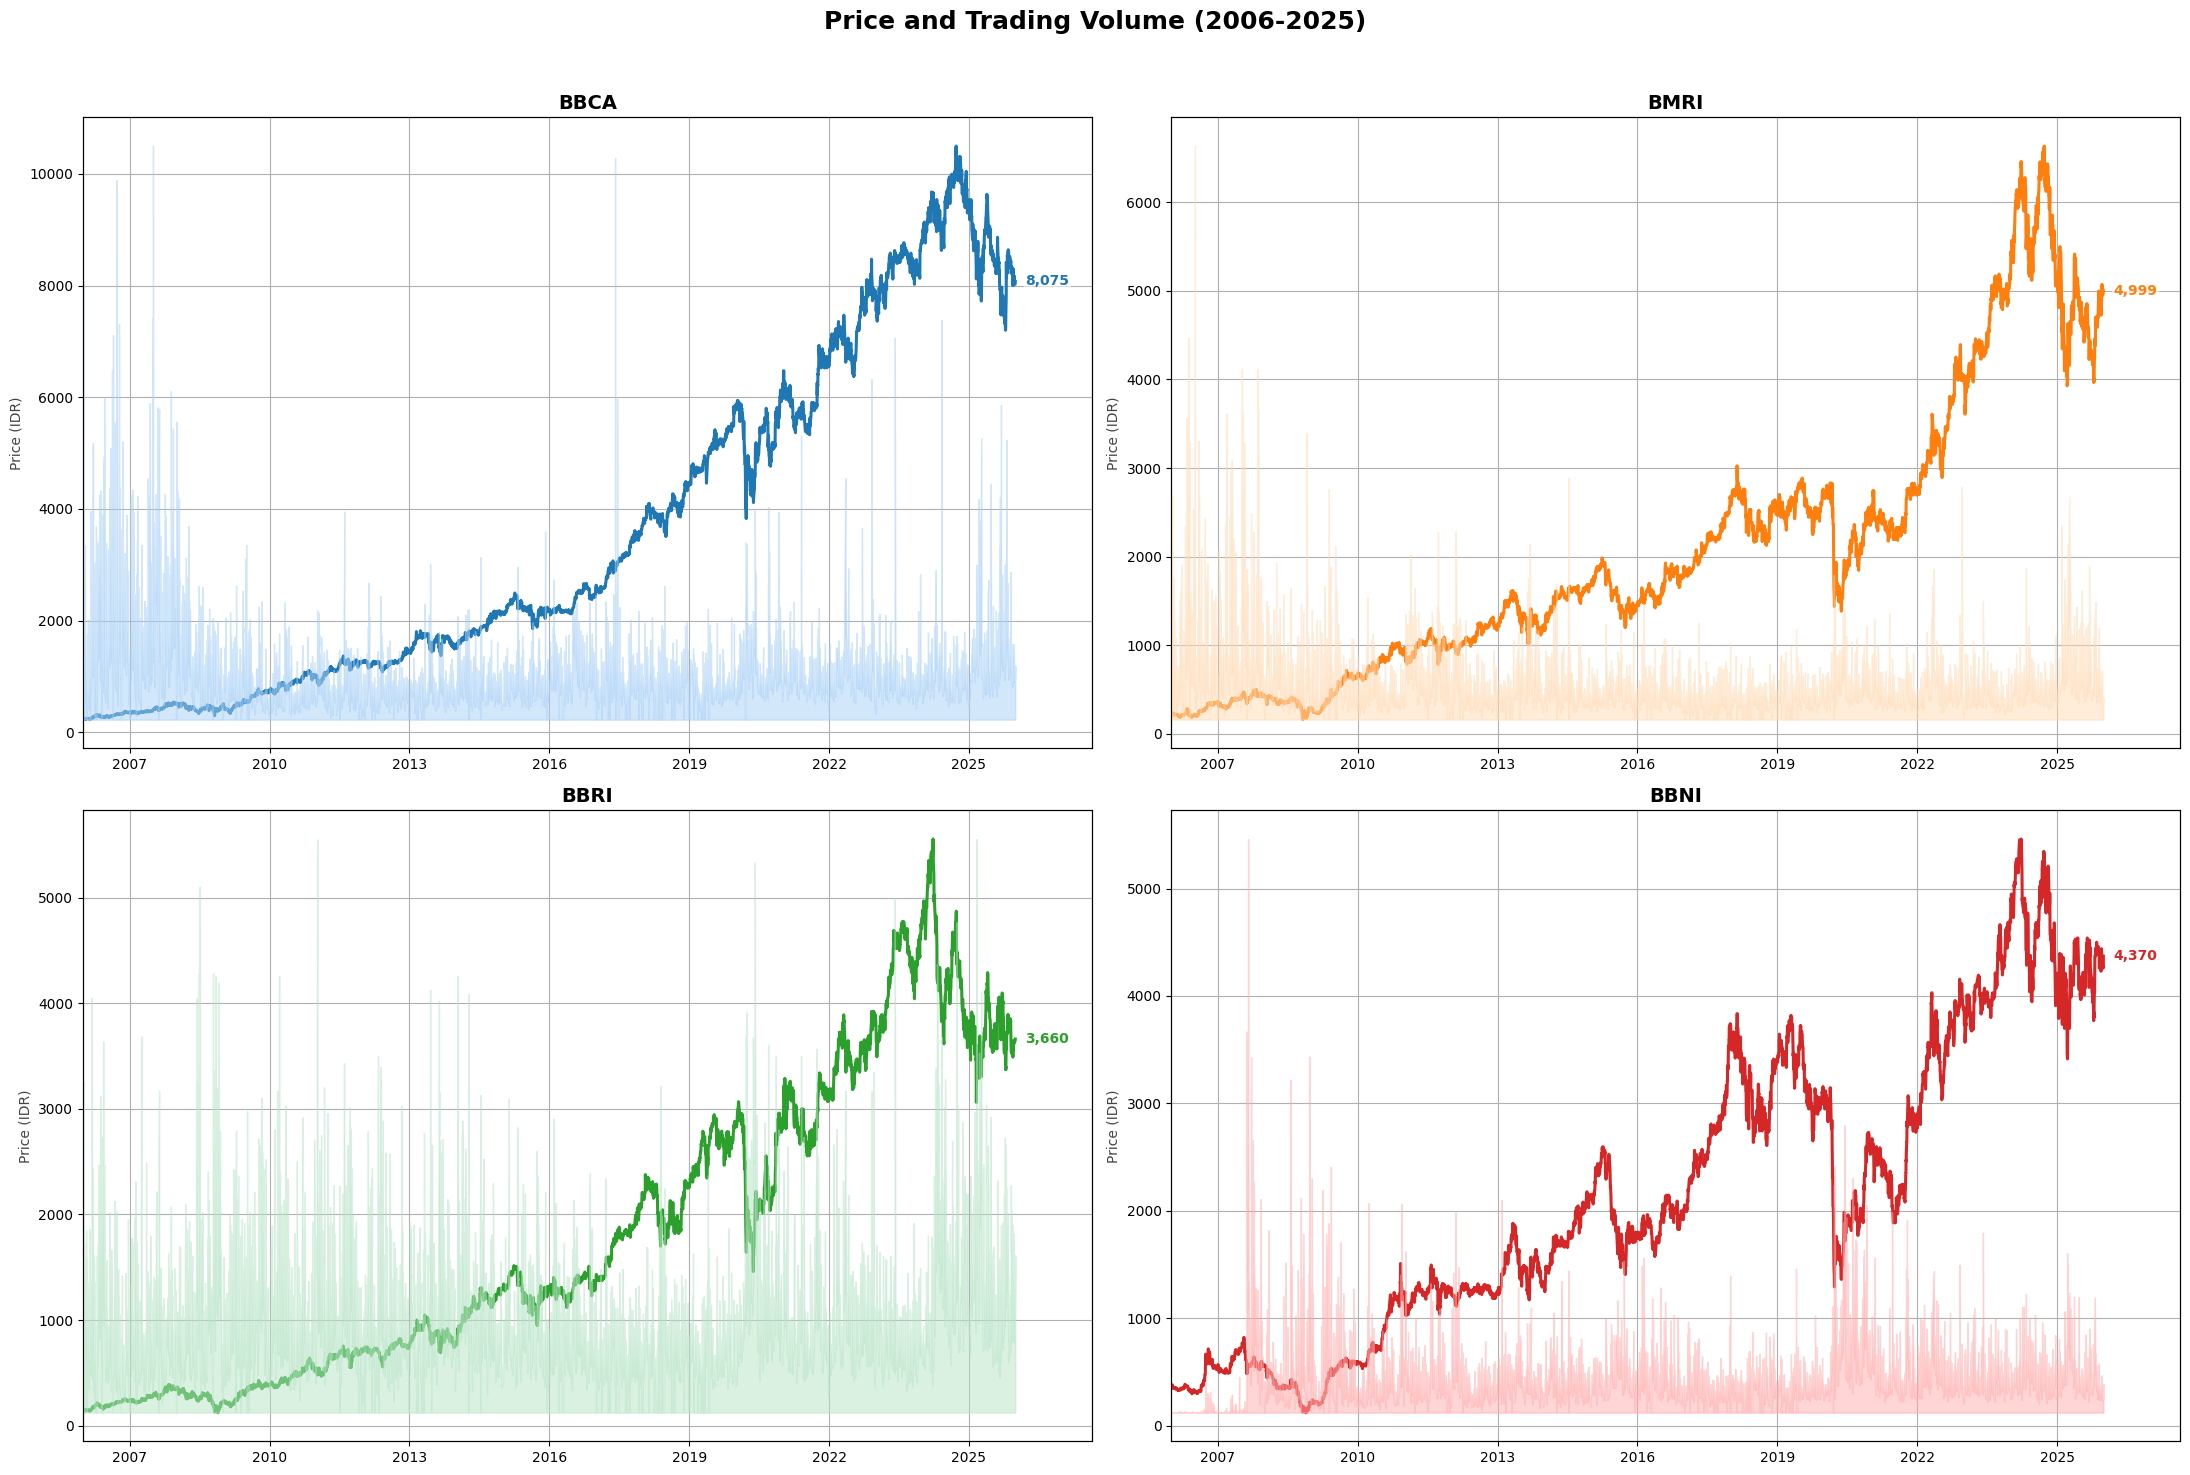

In [33]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
volume_colors = ['#a9d1f7', '#ffdbb5', '#b7e4c7', '#ffadad']
data_price = prices.loc[START_DATE:END_DATE, TICKERS].copy()
data_volume = volume.loc[START_DATE:END_DATE, TICKERS].copy()
data_price.columns = data_price.columns.str.replace('.JK', '', regex=False)
data_volume.columns = data_volume.columns.str.replace('.JK', '', regex=False)
fig, axes = plt.subplots(2, 2, figsize=(22, 15))
axes = axes.flatten()

for i, col in enumerate(data_price.columns):
    ax = axes[i]
    ax2 = ax.twinx()

    price_series = data_price[col].dropna()
    volume_series = data_volume[col].loc[price_series.index]

    if price_series.empty:
        continue

    ax2.fill_between(volume_series.index, volume_series, color=volume_colors[i], alpha=0.5, label='Volume')
    ax.plot(price_series.index, price_series, linewidth=2.2, color=colors[i], zorder=3)
    last_date = price_series.index[-1]
    last_price = price_series.iloc[-1]
    ax.text(last_date + pd.Timedelta(days=80), last_price, f"{last_price:,.0f}", fontsize=10, fontweight='bold', color=colors[i], va='center',bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))
    ax.set_title(f"{col}", fontsize=14, fontweight='bold', loc='center')
    ax.set_ylabel('Price (IDR)', fontsize=10, color='#444444')
    ax2.set_yticks([])
    ax.xaxis.set_major_locator(mdates.YearLocator(3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True)
    ax.set_xlim(price_series.index[0], price_series.index[-1] + pd.Timedelta(days=600))

fig.suptitle(f'Price and Trading Volume (2006-2025)', fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## **Cumulative Returns**

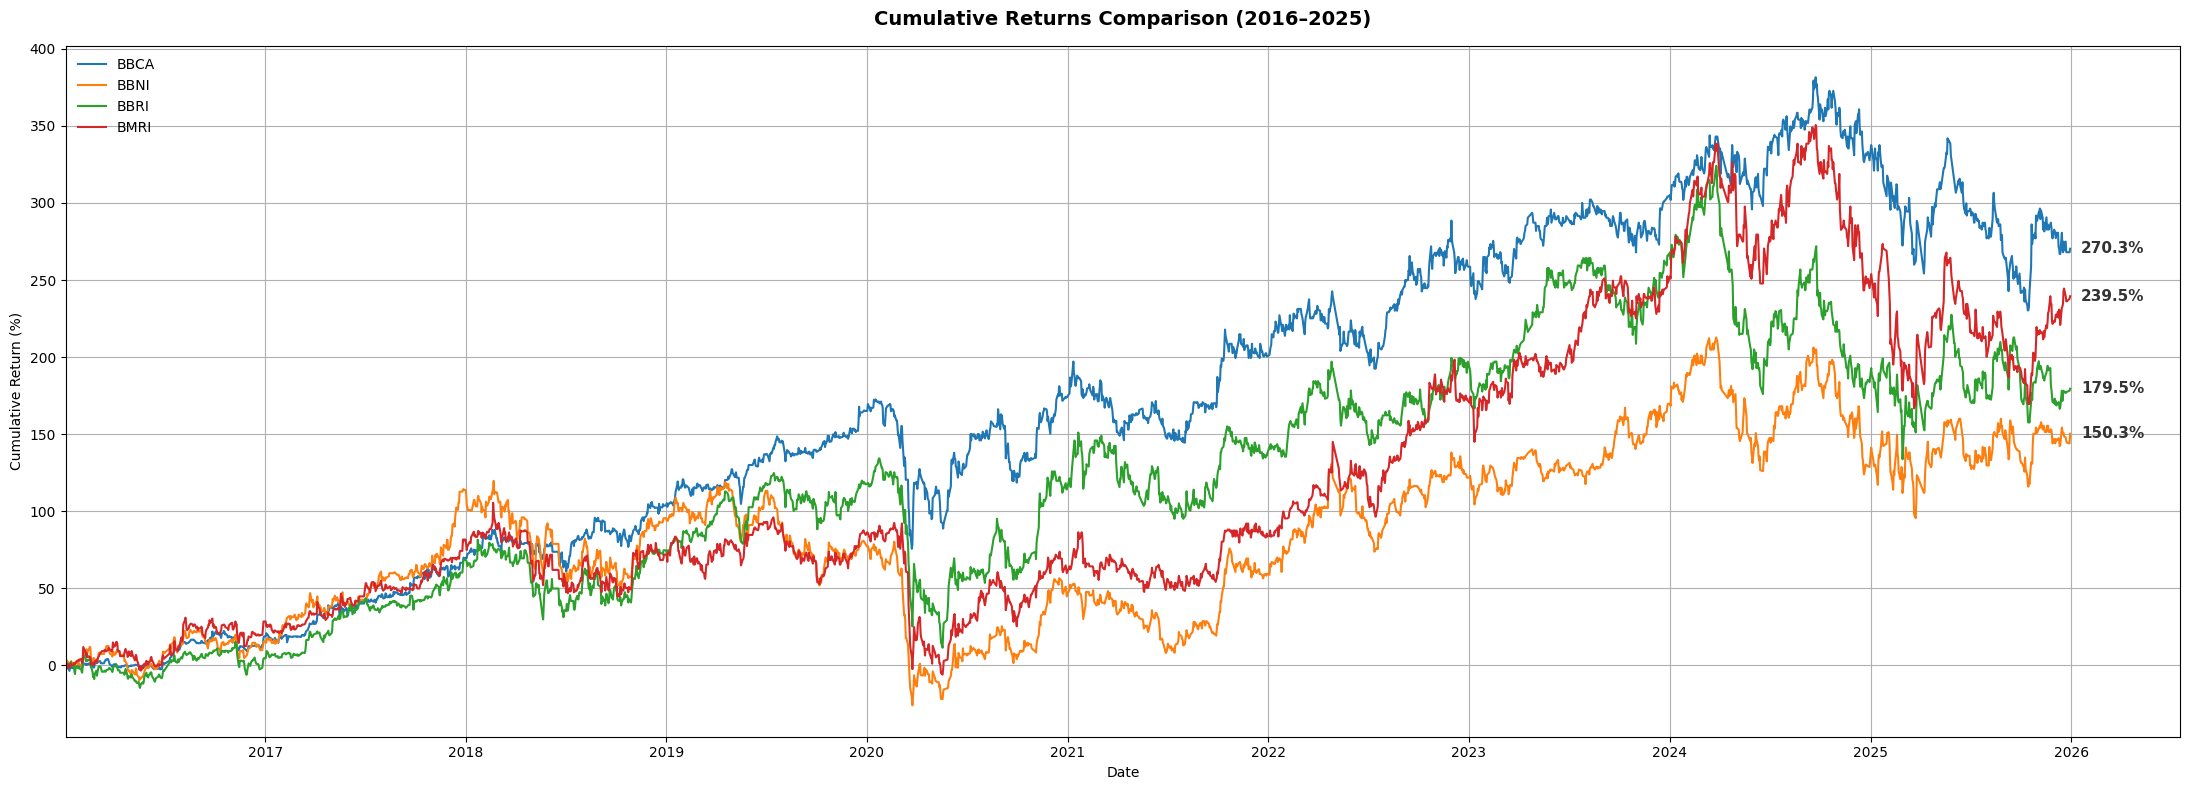

In [10]:
data_actual_plot = prices.loc['2016-01-01':'2025-12-31'].copy()
cum_ret_assets = ((data_actual_plot / data_actual_plot.iloc[0]) - 1) * 100
fig, ax = plt.subplots(figsize=(22, 8), facecolor='white')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, col in enumerate(cum_ret_assets.columns):
    ax.plot(cum_ret_assets.index,cum_ret_assets[col],linewidth=1.5,label=col.replace('.JK', ''),color=colors[i])

last_date = cum_ret_assets.index[-1]
offset = pd.Timedelta(days=20)
for col in cum_ret_assets.columns:
    y = cum_ret_assets[col].iloc[-1]
    ax.text(last_date + offset,y,f"{y:.1f}%",fontsize=11,va='center',fontweight='bold',color='#333333')

ax.set_title('Cumulative Returns Comparison (2016–2025)', fontsize=14, pad=15, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (%)')
ax.legend(loc='upper left', frameon=False)
ax.grid(True)
ax.set_xlim(cum_ret_assets.index[0],last_date + pd.Timedelta(days=200))
plt.tight_layout()
plt.show()

## **Drawdown Analysis**

0% Drawdown
1. Artinya portofolio tidak mengalami penurunan dari nilai tertingginya.
2. Portofolio selalu naik atau stabil, tidak ada kerugian sementara.

Drawdown positif (misal 10%, 20%)
1. Artinya portofolio turun sekian persen dari puncak sebelumnya.
2. Menunjukkan risiko penurunan nilai investasi yang pernah terjadi.

Drawdown tinggi (misal >50%)
1. Artinya portofolio mengalami penurunan besar dari puncak sebelumnya.
2. Risiko ekstrem, investor mengalami kerugian signifikan sebelum bisa kembali ke level awal.


Semakin rendah Drawdown, portofolio lebih stabil dan risiko kerugian lebih kecil.

Semakin tinggi Drawdown, portofolio lebih berisiko dan fluktuasi nilainya besar.

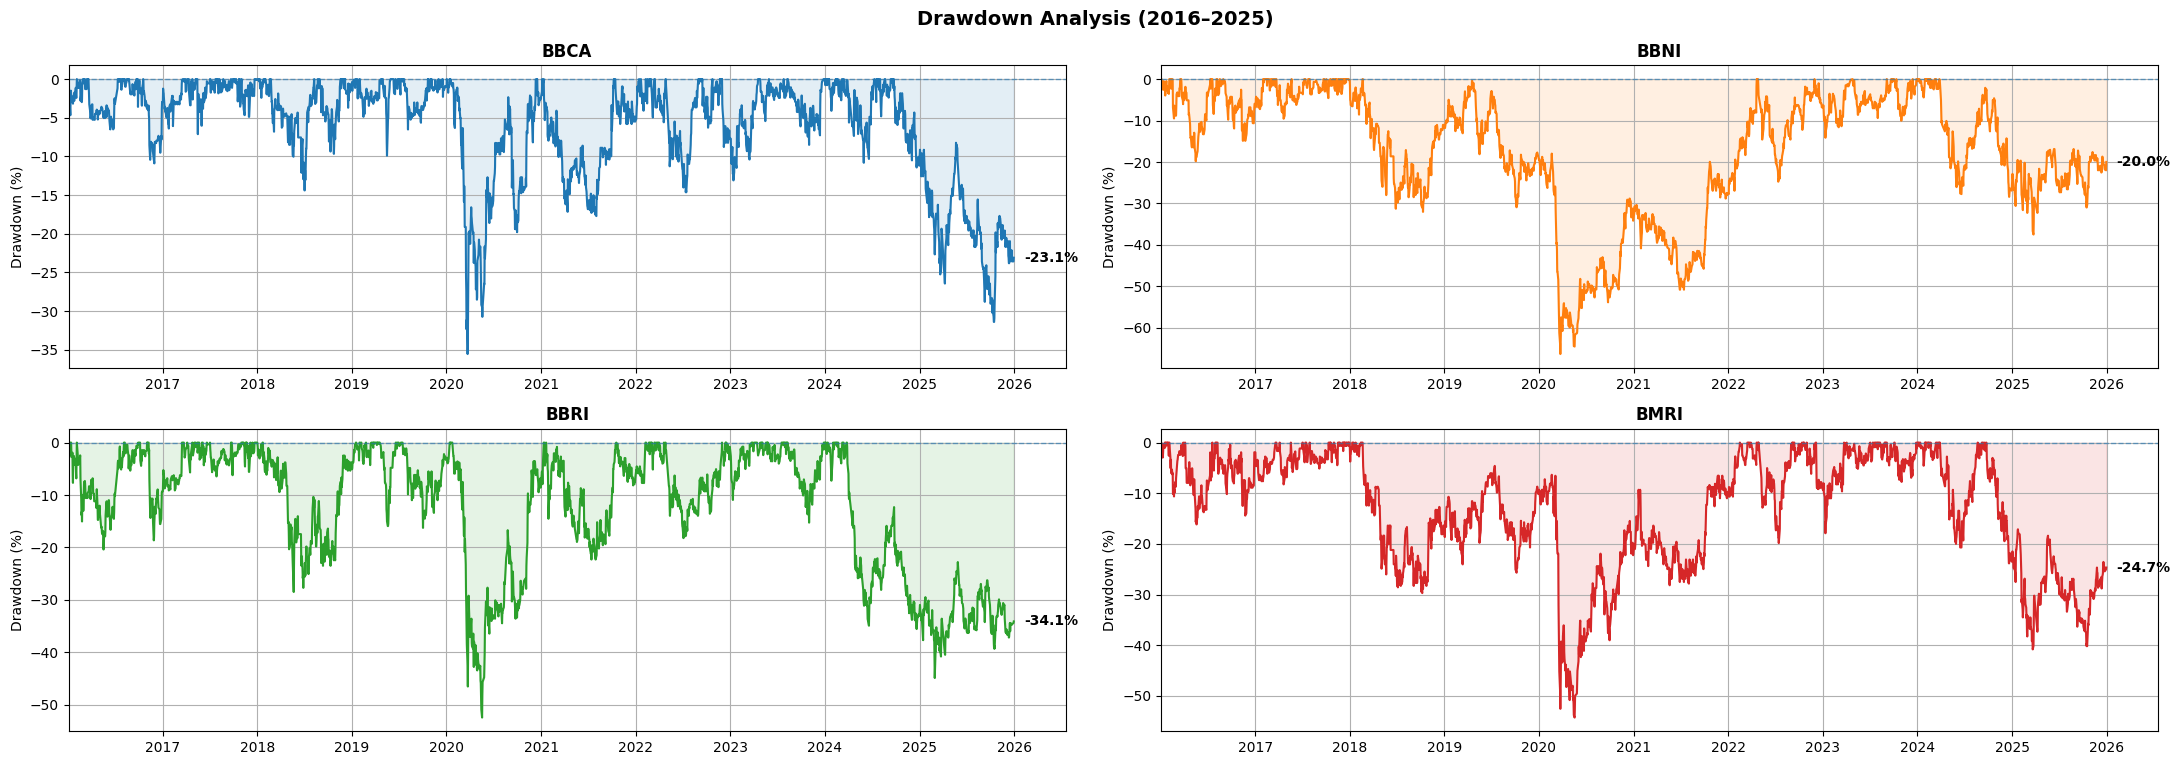

In [11]:
data_drawdown = prices.loc['2016-01-01':'2025-12-31']
rolling_max = data_drawdown.cummax()
drawdowns_pct = (data_drawdown / rolling_max - 1) * 100
fig, axes = plt.subplots(2, 2, figsize=(22, 8), sharex=False)
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, col in enumerate(drawdowns_pct.columns):
    ax = axes[i]
    ax.plot(drawdowns_pct.index,drawdowns_pct[col],linewidth=1.5,color=colors[i])
    ax.fill_between(drawdowns_pct.index,drawdowns_pct[col],0,color=colors[i],alpha=0.12)
    ax.axhline(0, linestyle='--', linewidth=1, alpha=0.6)
    last_date = drawdowns_pct.index[-1]
    last_value = drawdowns_pct[col].iloc[-1]
    ax.text(last_date + pd.Timedelta(days=40),last_value,f"{last_value:.1f}%",fontsize=10,va='center',fontweight='bold')
    ax.set_title(col.replace('.JK', ''), fontsize=12,fontweight='bold')
    ax.set_ylabel('Drawdown (%)')
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True)
    ax.set_xlim(drawdowns_pct.index[0],drawdowns_pct.index[-1] + pd.Timedelta(days=200))

fig.suptitle('Drawdown Analysis (2016–2025)', fontsize=14, y=0.98,fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

## **Sharpe Ratio vs Sortino Ratio Analysis**

0 Sharpe Ratio
1. Artinya return portofolio sama dengan aset bebas risiko, tidak ada kompensasi untuk risiko.
2. Portofolio tidak menghasilkan keuntungan tambahan dibanding menaruh uang di aset aman.

Sharpe Ratio positif
1. Artinya portofolio memberikan return lebih besar dari risiko yang diambil.
2. Semakin tinggi angkanya, semakin efisien portofolio menghasilkan return per unit risiko.

Sharpe Ratio negatif
1. Artinya portofolio merugi dibanding aset bebas risiko, investor tidak mendapat kompensasi atas risiko yang diambil.
2. Menunjukkan performa portofolio buruk atau strategi tidak efektif.


Semakin tinggi Sharpe Ratio, semakin baik portofolio dalam memanfaatkan risiko untuk menghasilkan return.


Semakin rendah atau negatif, portofolio kurang efisien atau bahkan merugikan.


0 Sortino Ratio
1. Artinya return portofolio sama dengan target minimum atau aset bebas risiko.
2. Tidak ada kompensasi atas risiko kerugian.
3. Portofolio tidak memberi nilai tambah dibanding menyimpan dana di instrumen aman.

Sortino Ratio positif

1. Artinya portofolio menghasilkan return di atas target dengan risiko kerugian yang terkontrol.
2. Semakin tinggi angkanya, semakin efisien portofolio menghasilkan return tanpa banyak downside.
3. Ini menunjukkan kualitas return yang lebih stabil dan bersih.

Sortino Ratio negatif

1. Artinya return portofolio berada di bawah target atau risk-free rate.
2. Kerugian lebih dominan daripada keuntungan.
3. Investor mengambil risiko downside tanpa imbal hasil yang layak.

Semakin tinggi Sortino Ratio, semakin baik portofolio dalam menghasilkan return dengan meminimalkan kerugian.

Semakin rendah atau negatif, portofolio sering mengalami downside dan strategi cenderung tidak efektif.

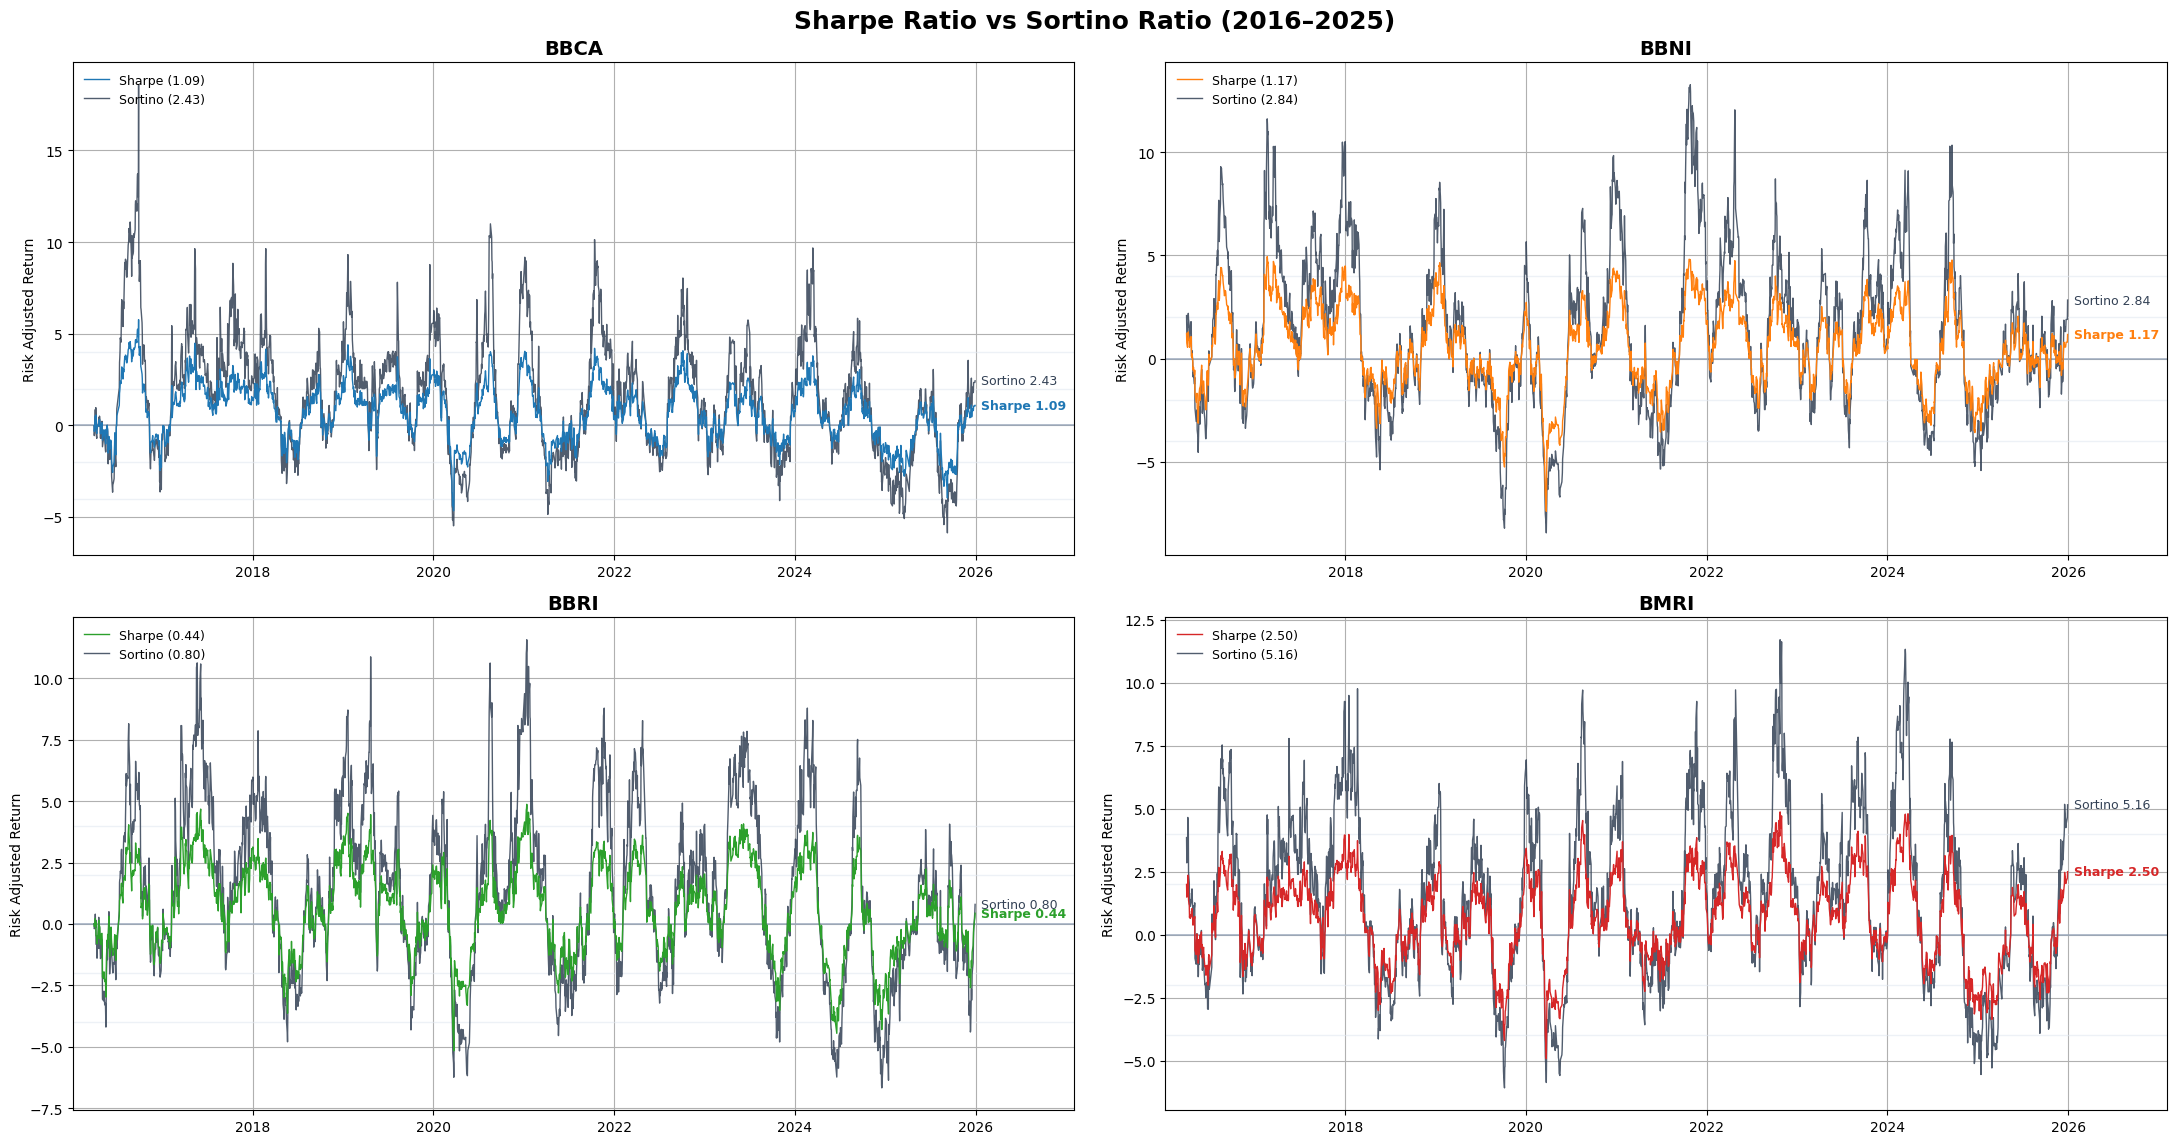

In [14]:
prices_eval = prices.loc['2016-01-01':'2025-12-31']
daily_returns = prices_eval.pct_change().dropna()
window = 60
trading_days = 252
risk_free_rate_annual = 0.04
risk_free_rate_daily = risk_free_rate_annual / trading_days
excess_returns = daily_returns - risk_free_rate_daily
rolling_sharpe = (excess_returns.rolling(window).mean() /excess_returns.rolling(window).std()) * np.sqrt(trading_days)

def calculate_rolling_sortino(returns, rf_daily, window_size, ann_factor):
    excess = returns - rf_daily
    downside = excess.copy()
    downside[downside > 0] = 0
    downside_std = downside.rolling(window_size).std()
    return (excess.rolling(window_size).mean() / downside_std) * np.sqrt(ann_factor)

rolling_sortino = calculate_rolling_sortino(daily_returns,risk_free_rate_daily,window,trading_days)
colors_sharpe = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
color_sortino = '#334155'
color_grid = '#e2e8f0'
color_zero = '#94a3b8'
fig, axes = plt.subplots(2, 2, figsize=(22, 12), sharex=False)
axes = axes.flatten()

for i, col in enumerate(daily_returns.columns[:4]):
    ax = axes[i]
    clean_name = col.replace('.JK', '')
    sharpe_series = rolling_sharpe[col]
    sortino_series = rolling_sortino[col]
    last_sharpe = sharpe_series.iloc[-1]
    last_sortino = sortino_series.iloc[-1]
    last_date = sharpe_series.index[-1]
    ax.plot(sharpe_series.index,sharpe_series,linewidth=1,color=colors_sharpe[i],label=f"Sharpe ({last_sharpe:.2f})",zorder=3)
    ax.plot(sortino_series.index,sortino_series,linewidth=1,color=color_sortino,alpha=0.85,label=f"Sortino ({last_sortino:.2f})",zorder=2)

    for y in [-4, -2, 2, 4]:
        ax.axhline(y,linestyle='-',linewidth=1,color=color_grid,alpha=0.6,zorder=1)

    ax.axhline(0,linewidth=1.1,color=color_zero,alpha=0.9,zorder=1)
    ax.text(last_date + pd.Timedelta(days=25),last_sharpe,f"Sharpe {last_sharpe:.2f}",fontsize=9,fontweight='bold',color=colors_sharpe[i],va='center')
    ax.text(last_date + pd.Timedelta(days=25),last_sortino,f"Sortino {last_sortino:.2f}",fontsize=9,color=color_sortino,va='center')
    ax.set_title(clean_name, fontsize=14, fontweight='bold')
    ax.set_ylabel("Risk Adjusted Return")
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.legend(loc='upper left',frameon=False,fontsize=9)
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=0, labelsize=10)
    ax.set_xlim(sharpe_series.index[0],sharpe_series.index[-1] + pd.Timedelta(days=400))

fig.suptitle("Sharpe Ratio vs Sortino Ratio (2016–2025)",fontsize=18,fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

## **Volatility Analysis**

0% volatility
1. Artinya harga aset tidak bergerak sama sekali selama periode yang dihitung.
2. Tidak ada fluktuasi harian, portofolio atau saham “stabil sempurna”.
3. Dalam praktik nyata hampir tidak pernah terjadi kecuali saham tidak diperdagangkan.

100% volatility
1. Artinya harga aset bergerak sangat besar dalam setahun.
2. Jika saham bernilai 100, bisa bergerak ±100 dalam setahun.
3. Menunjukkan risiko ekstrem, investasi sangat tidak stabil.


Semakin tinggi persentase, semakin besar fluktuasi dan risiko.

Semakin rendah persentase, harga lebih stabil, risiko lebih kecil.

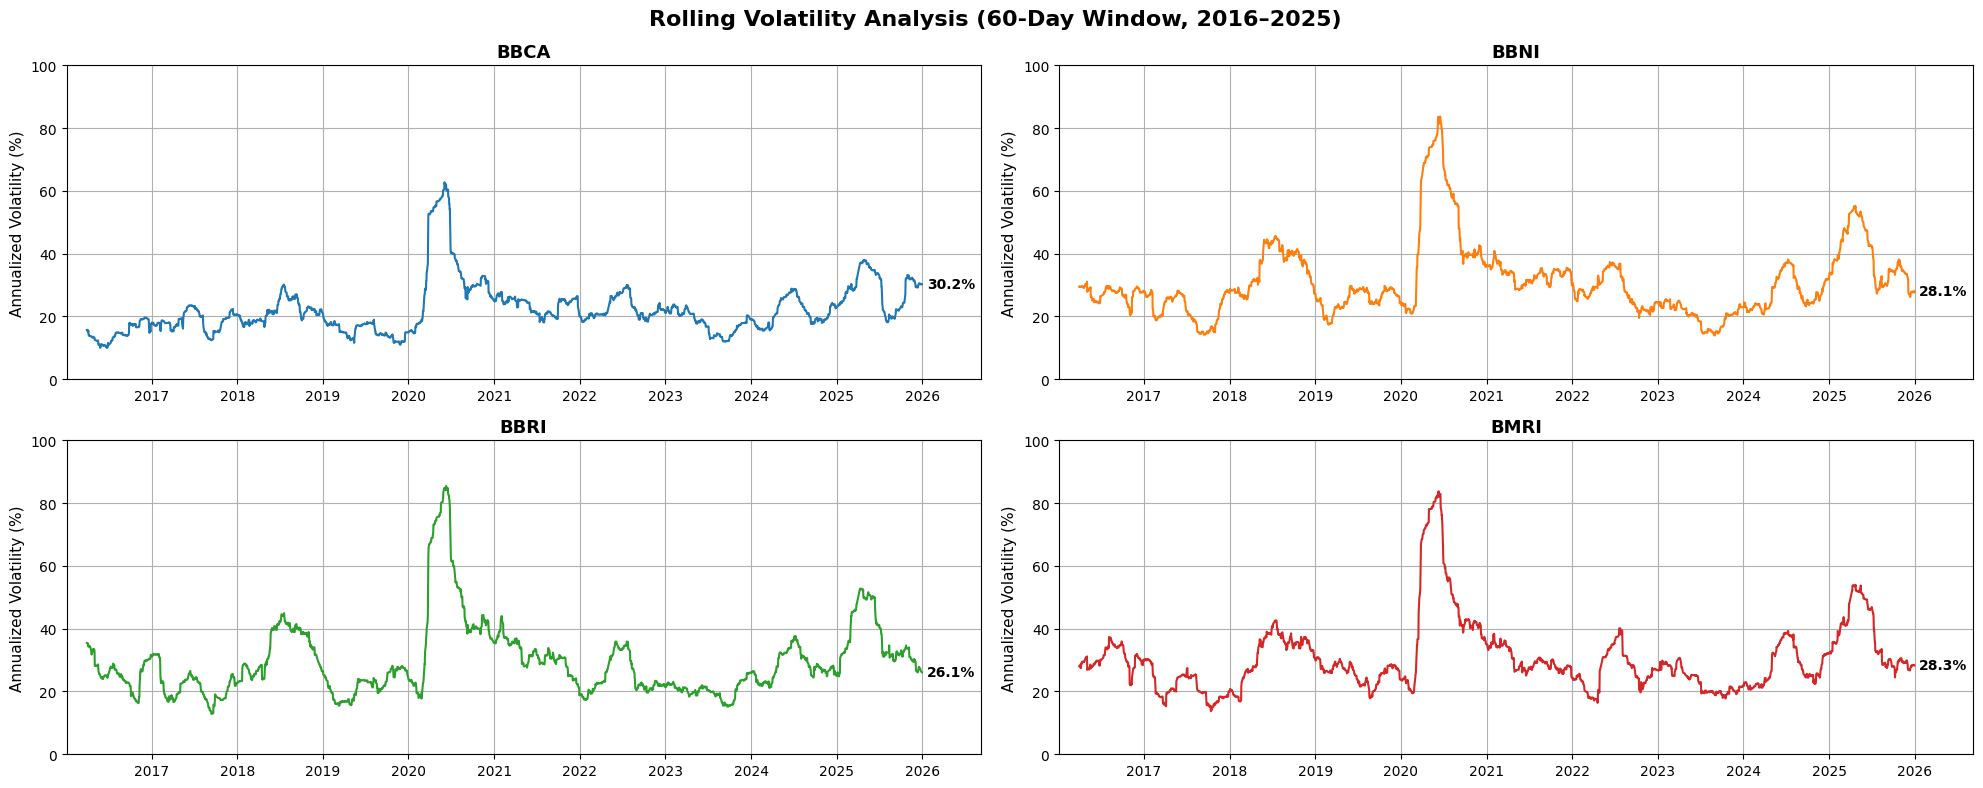

In [15]:
data_vol = prices.loc['2016-01-01':'2025-12-31']
daily_returns = data_vol.pct_change().dropna()
window = 60
rolling_vol = daily_returns.rolling(window).std() * np.sqrt(252) * 100
fig, axes = plt.subplots(2, 2, figsize=(20, 8), sharey=True)
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
y_ticks = np.arange(0, 101, 20)

for i, col in enumerate(rolling_vol.columns):
    ax = axes[i]
    ax.plot(rolling_vol.index, rolling_vol[col], linewidth=1.5, color=colors[i])
    ax.set_title(col.replace('.JK', ''), fontsize=13, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.set_yticks(y_ticks)
    ax.set_ylabel('Annualized Volatility (%)', fontsize=11)
    ax.tick_params(axis='y', labelleft=True)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True)
    last_date = rolling_vol.index[-1]
    val = rolling_vol[col].iloc[-1]

    if not np.isnan(val):
        ax.text(last_date + pd.Timedelta(days=20), val, f"{val:.1f}%", fontsize=10, fontweight='bold', va='center')

    ax.set_xlim(rolling_vol.index[0], last_date + pd.Timedelta(days=250))

fig.suptitle('Rolling Volatility Analysis (60-Day Window, 2016–2025)', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## **Correlation Heatmap**

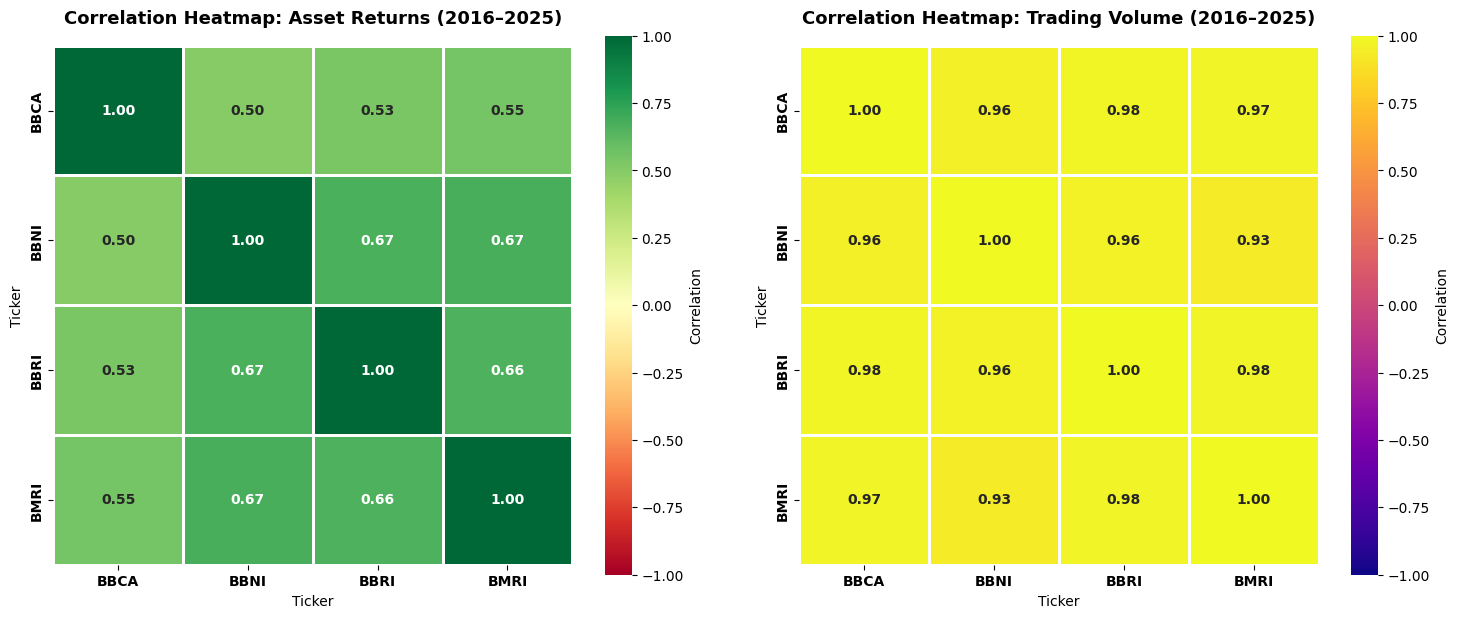

In [21]:
prices_eval = prices.loc['2016-01-01':'2025-12-31']
prices_eval.columns = prices_eval.columns.str.replace('.JK', '', regex=False)
daily_returns = prices_eval.pct_change().dropna()
corr_matrix_ret = daily_returns.corr()
volume_eval = volume.loc['2016-01-01':'2025-12-31']
volume_eval.columns = volume_eval.columns.str.replace('.JK', '', regex=False)
volume_returns = np.log(volume_eval.replace(0, 1) / volume_eval.shift(1).replace(0, 1)).dropna()
volume_returns = volume_returns.replace([np.inf, -np.inf], 0).fillna(0)
corr_matrix_vol = volume_returns.corr()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), facecolor='white')

sns.heatmap(corr_matrix_ret, annot=True, fmt=".2f", cmap='RdYlGn', vmin=-1, vmax=1, square=True, linewidths=1, annot_kws={"fontsize": 10, "fontweight": "bold", "ha": "center", "va": "center"}, cbar_kws={"label": "Correlation"}, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), fontweight='bold')
ax1.set_yticklabels(ax1.get_yticklabels(), fontweight='bold')
ax1.set_title("Correlation Heatmap: Asset Returns (2016–2025)", fontsize=13, pad=16, fontweight='bold')

sns.heatmap(corr_matrix_vol, annot=True, fmt=".2f", cmap='plasma', vmin=-1, vmax=1, square=True, linewidths=1, annot_kws={"fontsize": 10, "fontweight": "bold", "ha": "center", "va": "center"}, cbar_kws={"label": "Correlation"}, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), fontweight='bold')
ax2.set_yticklabels(ax2.get_yticklabels(), fontweight='bold')
ax2.set_title("Correlation Heatmap: Trading Volume (2016–2025)", fontsize=13, pad=16, fontweight='bold')

plt.subplots_adjust(wspace=0.15)
plt.show()

# **Three Dimensional Analysis of Threshold Conditions for Positive Expected Value**

Probability of Win (p) : Probabilitas win dari 0 - 100%

Average Expected Loss % (L) : Rata rata loss yang mungkin terjadi jika
investasi tersebut gagal , semakin ke angka 100 potensi kerugian semakin besar

Min Required Return (R) : target imbal hasil (keuntungan) minimal yang wajib di capai agar secara statistik Anda tidak rugi

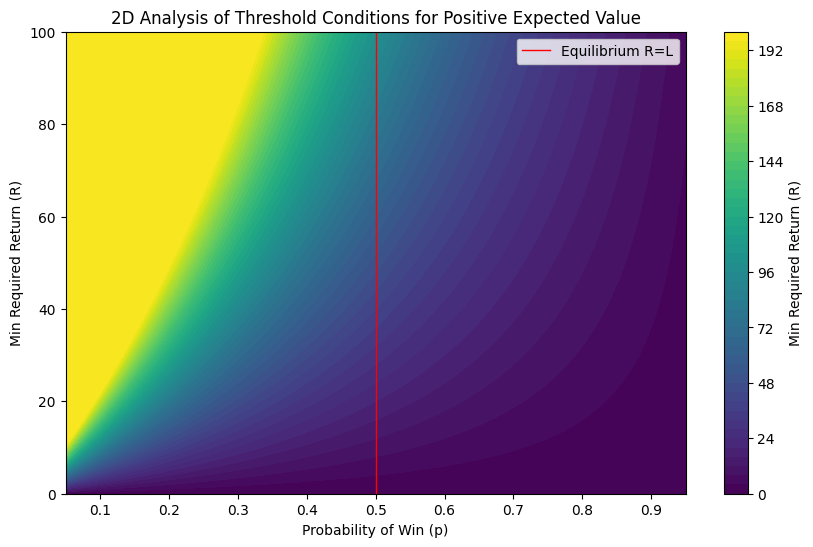

In [28]:
p = np.linspace(0.05, 0.95, 200)
l = np.linspace(0, 100, 200)
P, L = np.meshgrid(p, l)
R = (L * (1 - P)) / P
R_clipped = np.clip(R, 0, 200)

eq_l_smooth = np.linspace(0, 100, 500)
eq_p_smooth = []

for L_val in eq_l_smooth:
    def f(p):
        return (L_val * (1 - p)) / p - L_val
    p_sol, = fsolve(f, 0.5)
    eq_p_smooth.append(p_sol)

eq_r_smooth = eq_l_smooth
plt.figure(figsize=(10, 6))
cp = plt.contourf(P, L, R_clipped, levels=50, cmap='viridis')
plt.colorbar(cp, label='Min Required Return (R)')
plt.plot(eq_p_smooth, eq_r_smooth, color='red', linewidth=1, label='Equilibrium R=L')
plt.xlabel('Probability of Win (p)')
plt.ylabel('Min Required Return (R)')
plt.title('2D Analysis of Threshold Conditions for Positive Expected Value')
plt.legend()
plt.show()

In [30]:
for L_val in eq_l_smooth:
    def f(p):
        return (L_val * (1 - p)) / p - L_val
    p_sol, = fsolve(f, 0.5)
    eq_p_smooth.append(p_sol)

eq_r_smooth = eq_l_smooth

fig = go.Figure(data=[go.Surface(
    x=P, y=L, z=R_clipped, colorscale='Viridis',
    colorbar=dict(title='Min Required Return (R)'),
    hovertemplate='Prob of Win (p): %{x:.2f}<br>Avg Expected Loss (L): %{y:.2f}%<br>Min Required Return (R): %{z:.2f}%<extra></extra>'
)])

fig.add_trace(go.Scatter3d(
    x=eq_p_smooth,
    y=eq_l_smooth,
    z=eq_r_smooth,
    mode='lines',
    line=dict(color='red', width=4),
    name='Equilibrium',
    hovertemplate='Prob of Win (p): %{x:.2f}<br>Avg Loss (L): %{y:.2f}%<br>R: %{z:.2f}%<extra></extra>'
))

fig.update_layout(
    title='Three Dimensional Analysis of Threshold Conditions for Positive Expected Value',
    scene=dict(
        xaxis_title='Probability of Win (p)',
        yaxis_title='Average Expected Loss % (L)',
        zaxis_title='Min Required Return (R)',
        xaxis=dict(nticks=10, range=[0, 1], backgroundcolor="rgb(230, 230,230)"),
        yaxis=dict(nticks=10, range=[0, 100], backgroundcolor="rgb(230, 230,230)"),
        zaxis=dict(nticks=10, range=[0, 200], backgroundcolor="rgb(230, 230,230)"),
        aspectratio=dict(x=1, y=1, z=0.8),
        camera=dict(eye=dict(x=1.5, y=1.5, z=0.8))
    ),
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=50)
)

fig.show()